In [1]:
#Importing Libraries
from Plots import *
from Auxiliar_Functions import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import time    
from IPython.display import HTML

## Table of Contents:
* [1.EDOs](#first-bullet)
* [2.Results](#second-bullet)
    * [2.1 - Comparing Energies and M.O.](#2.1-bullet)
    * [2.2 - Comparing Angular Cases](#2.2-bullet)

# Angular Distribution

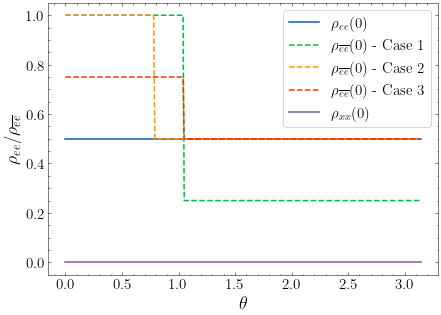

In [2]:
def theta_dist(theta,nu_type,case):
    if nu_type=="nu_x" or nu_type=="nu_x_bar":
        return np.where(theta<-100,0.0,0.0)
    
    if case==1:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/3,1,0.25)
    elif case==2:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/4,1,0.5)
    elif case==3:
        if nu_type=="nu_e":
            return np.where(theta<-100,0,0.5)
        if nu_type=="nu_e_bar":
            return np.where(theta<math.pi/3,0.5*1.5,0.5)
    else:
        print("Not a valid angular distribution!")

theta_vec=np.arange(0,math.pi,0.01)
plt.figure(figsize=(7,5))
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e",1),label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",1),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 1")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",2),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 2")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_e_bar",3),ls="--",label=r"$\rho_{\overline{ee}}(0)$ - Case 3")
plt.plot(theta_vec,theta_dist(theta_vec,"nu_x",1),label=r"$\rho_{xx}(0)$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

# 1. EDOs <a class="anchor" id="first-bullet"></a>

In [3]:
def initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case):
    y0=[] #Initial state
    flavor_sign=[1,-1]
    omega=delta_m2/(2*E_nu*10**6) #eV 

    theta_vec=np.linspace(0,np.pi,theta_bins)
    theta_step=theta_vec[1]-theta_vec[0]
    n_theta=len(theta_vec)
    n_f=len(nu_types)
    n_dim=(n_f**2)-1
    n_antipart=2

    index_order=[n_theta,n_f,n_dim,n_antipart]
    
    for i in range(n_theta):        
      for j in range(n_f):
        #nu
        nu_spec=theta_dist(theta_vec[i],nu_types[j],case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign[j]*nu_spec)
        #nubar
        nu_spec=theta_dist(theta_vec[i],nu_types[j]+'_bar',case)*theta_step
        y0.append(0)
        y0.append(0)
        y0.append(flavor_sign[j]*nu_spec)

    #t array
    t_i = t_i*c_const*from_eV_to_1_over_m #from s to eV⁻¹
    t_f = t_f*c_const*from_eV_to_1_over_m #from s to eV⁻¹
    t_step=(2*np.pi/max(omega,mu_0))/10
    t = np.arange(t_i,t_f,t_step) #eV⁻¹

    return y0,omega,E_nu,t,mu_0,n_f,n_dim,n_theta,theta_vec

In [4]:
def from_1D_to_MultiD(y,n_f,n_dim,n_theta):
    nu, nubar = [],[]    
    #Filling [Theta bin][Nu_Flavors][3components]    
    for i in range(n_theta):
      nu.append([])
      nubar.append([])
      for j in range(n_f):
        nu[i].append([])
        nubar[i].append([])
        for k in range(n_dim):
          #nu 
          nu_index=(i*2*n_dim*n_f)+(j*2*n_dim)+k
          nu[i][j].append(y[nu_index])
          #nubar   
          nubar_index=(i*2*n_dim*n_f)+(j*2*n_dim)+(k+n_dim)
          nubar[i][j].append(y[nubar_index])
    return nu, nubar 

In [5]:
def func_Collective_nu_v2(y, time, params):
    omega,E,theta_V,t,mu_0,n_f,n_dim,n_theta,theta_vec= params  # unpack parameters
    
    B=np.array(B_vec(n_dim,theta_V))
    L=np.array(L_vec(n_dim))
    mu=mu_0
    lamb=lambda_supernova(t,"no",0)

    derivs=[]
    nu, nubar = from_1D_to_MultiD(y,n_f,n_dim,n_theta)
    
    #Summed nu and nubar components
    nu_sum, nubar_sum=[],[]
    nu_sum_theta, nubar_sum_theta=[],[]
    nu_aux=np.transpose(nu,(2,0,1))
    nubar_aux=np.transpose(nubar,(2,0,1))

    for i in range(n_dim):
      nu_sum.append(sum(map(sum,nu_aux[i])))
      nubar_sum.append(sum(map(sum,nubar_aux[i])))
      nu_sum_theta.append(sum(theta_vec*list(map(sum,nu_aux[i]))))
      nubar_sum_theta.append(sum(theta_vec*list(map(sum,nubar_aux[i]))))
    
    nu_sum=np.array(nu_sum)
    nubar_sum=np.array(nubar_sum)
    nu_sum_theta=np.array(nu_sum_theta)
    nubar_sum_theta=np.array(nubar_sum_theta)
    
    # list of dy/dt=f functions
    for i in range(n_theta):
      for j in range(n_f):
        #nu
        aux=B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nu[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])
        
        #nubar
        aux=-1*B*omega+L*lamb-mu*((nu_sum-nubar_sum)-np.cos(theta_vec[i])*(nu_sum_theta-nubar_sum_theta))
        P_aux= cross_prod(nubar[i][j],aux)
        for k in range(n_dim):
          derivs.append(P_aux[k])

    return derivs

In [6]:
def solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord):

    y0,omega,E,t,mu_0,n_f,n_dim,n_theta,theta_vec=initiate_v2(nu_types,t_i,t_f,E_nu,delta_m2,mu_0,theta_bins,case)
    
    if mass_ord=="NH": 
        params=omega,E,theta_V,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
    elif mass_ord=="IH":
        params=-1*omega,E,theta_V,t,mu_0,n_f,n_dim,n_theta,np.array(theta_vec)
    else:
        print("Not a mass ordering option!")
    psoln= odeint(func_Collective_nu_v2, y0, t, args=(params,))

    nu, nubar= read_output(psoln,(n_f,n_dim,n_theta))    
    t=t/(c_const*from_eV_to_1_over_m) #From eV⁻¹ to km

    return theta_vec,t,mu_0, nu, nubar

# 2. Resuts <a class="anchor" id="second-bullet"></a>

## 2.1 - Comparing Energies and M.O. <a class="anchor" id="2.1-bullet"></a>

In [7]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["IH",1,1],["NH",1,1],["NH",1,10],["NH",1,10**4]]
# scenarios=[["IH",1,1]]
mu_0=1*10**2 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,10*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins


# print("mu=%.1e eV = %.1e s⁻¹"%(mu_0,mu_0*from_eV_to_1_over_m*3*10**8))
# print("w=%.1e eV =%.1e s⁻¹= %.1e km⁻¹"%(delta_m2_31/(2*E_nu*10**6),delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_m*3*10**8,delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_km))
# print("T_vac=%.1e s"%(2*np.pi/(delta_m2_31/(2*E_nu*10**6)*from_eV_to_1_over_m*3*10**8)))
# print("t_step=%.1e s"%(t_f/1000))
# print("f_sampling = %.1e s⁻¹"%(1/(t_f/5000)))
# print("t_f=%.1e km"%(t_f*3*10**5))

In [8]:
nu,nubar=[],[]
for mass_ord,case,E_nu in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)

Took 0.6219386180241903 minutes
Took 0.3875551501909892 minutes
Took 0.758201018969218 minutes
Took 0.774360732237498 minutes


In [9]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]

for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu,(0,1,2,4,3))[i][0][0]**2+np.transpose(nu,(0,1,2,4,3))[i][1][0]**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*theta_step/np.pi)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu,(0,1,2,4,3))[i][2][0][j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*theta_step/np.pi)
    

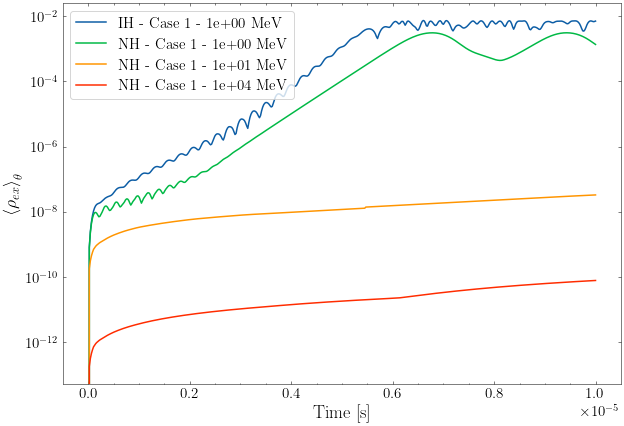

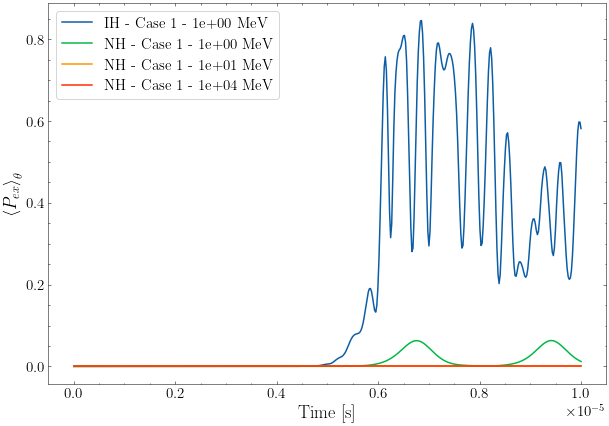

In [10]:
x_min,x_max=0,10*10**-6

plt.figure(figsize=(10,7))
for i in range(len(scenarios)):
    plt.plot(t,rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.xlim(x_min,x_max)
plt.yscale('log')

plt.figure(figsize=(10,7))
for i in range(len(scenarios)):
    plt.plot(t,P_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.xlim(x_min,x_max)
# plt.yscale('log')

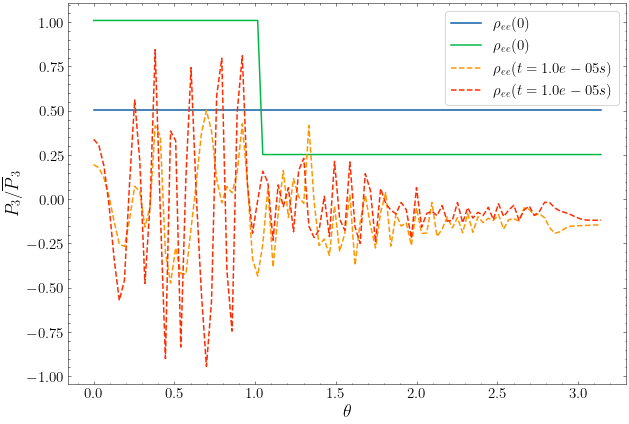

In [79]:
# theta_vec=np.linspace(0,np.pi,theta_bins)
theta_step=np.pi/theta_bins
t_i=-1
plt.figure(figsize=(10,7))
plt.plot(theta_vec,np.array(nu[0][2][0][0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar[0][2][0][0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu[0][2][0][t_i])/theta_step,ls='--',label=r"$\rho_{ee}(t=%.1e s)$"%(t[t_i]))
plt.plot(theta_vec,np.array(nubar[0][2][0][t_i])/theta_step,ls='--',label=r"$\rho_{ee}(t=%.1e s)$"%(t[t_i]))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$P_{3}$/$\overline{P}_3$")
plt.legend()
plt.show()

In [ ]:
nu_e_time,nubar_e_time, nu_x_time,nubar_x_time=read_two_flavor_v2(nu[0], nubar[0])

In [ ]:
# theta_vec=np.linspace(0,np.pi,theta_bins)
theta_step=np.pi/theta_bins
t_i=140

plt.figure(figsize=(10,7))
plt.plot(theta_vec,np.array(nu_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nubar_e_time[0])/theta_step,label=r"$\rho_{ee}(0)$")
plt.plot(theta_vec,np.array(nu_e_time[t_i])/theta_step,ls='--',label=r"$\rho_{ee}(t=%.1e s)$"%(t[t_i]/(3*10**5*from_eV_to_1_over_km)))
plt.plot(theta_vec,np.array(nubar_e_time[t_i])/theta_step,ls='--',label=r"$\rho_{ee}(tt=%.1e s)$"%(t[t_i]/(3*10**5*from_eV_to_1_over_km)))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\rho_{ee}$/$\rho_{\overline{ee}}$")
plt.legend()
plt.show()

## 2.2 - Comparing Angular Cases <a class="anchor" id="2.2-bullet"></a>

In [84]:
#Neutrino Mixing
delta_m2=delta_m2_31
theta_V=10**-6 #rad
nu_types=['nu_e','nu_x']

#Neutrino Scenario
scenarios=[["NH",1,1],["NH",2,1],["NH",3,1]]
mu_0=1*10**2 #km⁻¹
mu_0=mu_0/from_eV_to_1_over_km #eV

#Numerical Solver Info
t_i,t_f=0,10*10**(-6) #s
theta_bins=100
theta_step=np.pi/theta_bins

In [85]:
nu,nubar=[],[]
for mass_ord,case,E_nu in scenarios:
    start_time = time.time()
    theta_vec,t,mu_0, nu_aux, nubar_aux= solver_two_families_v2(nu_types,t_i,t_f,E_nu,delta_m2,theta_V,mu_0,theta_bins,case,mass_ord)
    print("Took %s minutes" % ((time.time() - start_time)/60))
    nu.append(nu_aux)
    nubar.append(nubar_aux)

Took 0.39509308338165283 minutes
Took 0.616478951772054 minutes
Took 0.6093028306961059 minutes


In [86]:
rho_ex_theta_time=[]
rho_ex_mean_time=[]
P_ex_theta_time=[]
P_ex_mean_time=[]

for i in range(len(scenarios)):
    rho_ex_theta_time_aux= 1/2*np.sqrt(np.transpose(nu,(0,1,2,4,3))[i][0][0]**2+np.transpose(nu,(0,1,2,4,3))[i][1][0]**2)
    rho_ex_theta_time.append(rho_ex_theta_time_aux)
    rho_ex_mean_time.append(sum(rho_ex_theta_time_aux)*theta_step/np.pi)
    
    P_ex_theta_time_aux=[]
    for j in range(theta_bins):
        P_ex_theta_time_aux.append(1/2*(1-np.transpose(nu,(0,1,2,4,3))[i][2][0][j]/nu[i][2][0][0][j]))
    P_ex_theta_time.append(P_ex_theta_time_aux)
    P_ex_mean_time.append(sum(P_ex_theta_time_aux)*theta_step/np.pi)
    

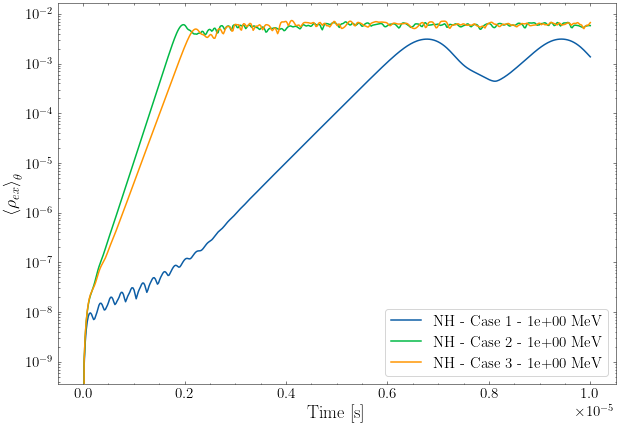

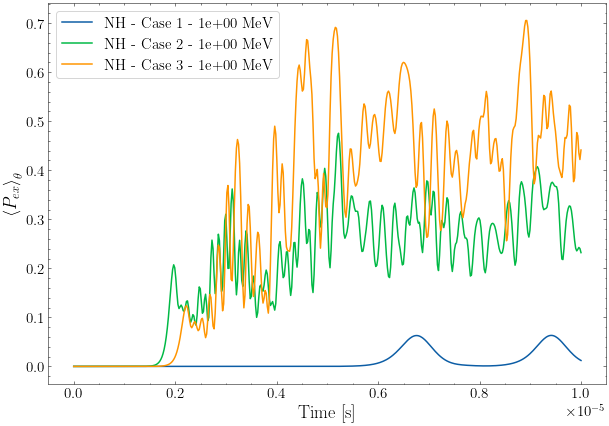

In [90]:
x_min,x_max=0,10*10**-6

plt.figure(figsize=(10,7))
for i in range(len(scenarios)):
    plt.plot(t,rho_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [s]")
plt.ylabel(r"$\left \langle  \rho_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.xlim(x_min,x_max)
plt.yscale('log')

plt.figure(figsize=(10,7))
for i in range(len(scenarios)):
    plt.plot(t,P_ex_mean_time[i],label="%s - Case %d - %.0e MeV"%(scenarios[i][0],scenarios[i][1],scenarios[i][2]))
plt.xlabel("Time [s]")
plt.ylabel(r"$\left \langle  P_{ex} \right \rangle_{\theta}$")
plt.legend()
# plt.xlim(x_min,x_max)
# plt.yscale('log')
plt.show()

# Draft <a class="anchor" id="draft-bullet"></a>